# Project

In [1]:
#  imports and set magics
import numpy as np
import pandas as pd
import tqdm
import time
import datetime
import os
import requests
from bs4 import BeautifulSoup
import re

## Web scraping 

### Define functions:

In [2]:
def log(response: requests.Response):
    """
    Creates or appends a log-file with information from a requests.get()-call.
    
    The information gathered is:
    - - - - - - - -
        timestamp   :   Current local time.
        status_code :   Status code from requests call.
        length      :   Length of the HTML-string.
        output_path :   Current working directory.
        url         :   The URL of the response.
    """

    # Open or create the csv file
    if os.path.isfile('log'):
        log = open('log','a')
    else: 
        log = open('log','w')
        header = ['timestamp', 'status_code', 'length', 'output_file', 'url'] # Header names
        log.write(';'.join(header) + "\n")
        
    # Gather log information
    status_code = response.status_code # Status code from the request result
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())) # Local time
    length = len(response.text) # Length of the HTML-string
    output_path = os.getcwd() # Output path
    url = response.url # URL-string
    
    # Open the log file and append the gathered log information
    with open('log','a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path};{url}' + "\n") 


def create_url(page: int) -> str:
    """
    Creates a PolitiFact URL with the given pagenumber.

    Input:
    - - - - - - - -
    page (int) :    Pagenumber for the PolitiFact website.

    Returns:
    - - - - - - - -
    url (str)  :    URL of the PolitiFact website for given page. 
    """

    url = f'https://www.politifact.com/factchecks/list/?page={page}' # Construct url with f-string

    return url


def get_soup(url: str, header: dict) -> BeautifulSoup:
    """
    Constructs a HTML-string from a request of the given URL. 
    Requests are logged, see log(). 

    Input:
    - - - - - - - - 
    url (str)     :    URL of the website to receive the HTML-string from. \n
    header (dict) :    Dictionary to send in the query string for the request.

    Returns:
    - - - - - - - - 
    soup (BeautifulSoup) :  HTML-string in the class of BeutifulSoup with 'lxml' parser.
    """

    response = requests.get(url, headers=header) # Request
    log(response) # Log 
    soup = BeautifulSoup(response.content, 'lxml') # Convert to response to HTML

    return soup


def extract_articles(soup: BeautifulSoup) -> list:
    """
    Extracts articles from HTML-string from the PolitiFact website.

    Input:
    - - - - - - - -
    soup (BeautifulSoup) : HTML-string from the PolitiFact website.

    Returns:
    - - - - - - - - 
    list_of_articles (list) : A list of all articles in the given soup. \n
                              Each element is an article of data structure as BeautifulSoup.
    """
    
    articles = soup.find(class_='o-listicle__list') # Find section with articles
    list_of_articles = articles.find_all('li') # Find all articles as a list

    return list_of_articles


def extract_info(article: BeautifulSoup) -> list:
    """
    Extracts all relevant information from an article on the PolitiFact website.

    Input:
    - - - - - - - - 
    article (BeautifulSoup) :  Article to extract data from, see extract_articles().

    Returns:
    - - - - - - - - 
    [name_txt, name_href, description_txt, quote_txt, quote_href, meter, footer] (list) \n 
    The name and URL of the quoted person, the description of the quote, the quote itself \n
    and link hereof, the truthfulness index, and information on the article in string-format.
    """

    # Statement name 
    name = article.find(class_='m-statement__name')
    name_txt = name.text # name 
    name_href = name['href'] # href

    # Statement description
    description_txt = article.find(class_='m-statement__desc').text

    # Statement quote
    quote = article.find(class_='m-statement__quote').a
    quote_txt = quote.text # name 
    quote_href = quote['href'] # href

    # Statement meter
    meter = article.find(class_='m-statement__meter').div.img['alt']

    # Statement footer
    footer = article.find(class_='m-statement__footer').text

    return [name_txt, name_href, description_txt, quote_txt, quote_href, meter, footer]


def data_politifact(startpage: int, endpage: int, header: dict) -> list:
    """
    Compound function that scrapes an interval of pages from PolitiFact and extracts information for analysis. \n
    Saves extracted information for each page in '/data'-folder as CSV, and logs requests in 'log'. 

    Input:
    - - - - - - - -
    startpage (int) :  The first page to scrape. \n
    endpage   (int) :  The last page to scrape. \n
    header    (dict):  Dictionary to send in the query string for the request.

    Returns:
    - - - - - - - -
    list_of_dfs (list) : A list of pandas.DataFrame containing the extracted information from each page.
    """

    list_of_dfs = [] # initialize empty list for dataframes

    # Loop through pages and track progress with tqdm
    for page in tqdm.tqdm(range(startpage, endpage+1)):
        url = create_url(page) # create url

        try: # circumvent problem with empty pages
            soup = get_soup(url, header) # construct html
            articles = extract_articles(soup) # extract articles 

            output = [] # initialize empty for articles 

            # Loop through articles 
            for article in articles:
                info = extract_info(article) # extract relevant information
                output.append(info) # append output

        except: # skip page
            continue

        # Create DataFrame
        output_df = pd.DataFrame(output, columns=['name_txt', 'name_href', 'description_txt', 'quote_txt', 'quote_href', 'meter', 'footer'])

        # Create data-folder if it doesn't exist
        path = os.getcwd() + '/page_data/'
        if not os.path.exists(path):
            os.makedirs(path)

        # Save CSV-file and append list of DataFrames
        output_df.to_csv(path + f'data_p{page}', index=False) # save csv
        list_of_dfs.append(output_df) # append df

        
        time.sleep(0.5) # sleep for 0.5 sec 

    return list_of_dfs


def get_article_data(article: BeautifulSoup) -> list:
    """
    A function that scrapes each individual article for relevant data. \n

    Input:
    - - - - - - - -
    article (BeautifulSoup) : BeatifulSoup element of article. \n
    
    Returns:
    - - - - - - - -
    [tags, sub_header, text_body, quote_href] : A list of of all relevant data from each politifact article.

    """

    # Extract tags
    tag_soup = article.find(class_='m-list m-list--horizontal')\
        .find_all('a') #Find all tags
    
    list_of_tags = [] #Create empty list for tags 
    
    for tag in tag_soup:
        list_of_tags.append(tag['title']) #Append each tag to list of tags

    # Extract sub-header
    sub_header = article.find(class_='c-title c-title--subline').text #conclusion by journalist

    # Extract entire text body
    text_block = article.find(class_='m-textblock') #Find article's body text
    text_body = []

    for paragraph in text_block.find_all('p'): #Find all paragraphs in article
        text_body.append(paragraph.text) #append them to list

    text_body=' '.join(text_body) #Convert to a single string

    return [list_of_tags, sub_header, text_body]


def get_all_articles(list_of_url: list, header: dict) -> pd.DataFrame:
    """
    A compound function that scrapes relevant data from each article on politifact.com and stores this in a DataFrame. \n

    Input:
    - - - - - - - -
    list_of_url (list) : A list of URL's for each article to scrape. \n
    header      (dict) : Dictionary to send in the query string for the request.
    
    Returns:
    - - - - - - - -
    list_of_dfs (list) : A list of of dataframe for each article.

    """

    # Split list_of_url into chunks of 30 URLs
    chunked_list = []
    for i in range(0, len(list_of_url), 30):
        chunked_list.append(list_of_url[i:i+30])

    # Create data-folder if it doesn't exist
    path = os.getcwd() + '/article_data/'
    if not os.path.exists(path):
        os.makedirs(path)

    list_of_dfs = [] # Initialize empty list for dataframes

    for it, chunk in tqdm.tqdm(enumerate(chunked_list)):
        output = [] # Initialize empty output list 

        # Loop through list of URls
        for article_url in chunk: 
            full_url = 'https://www.politifact.com' + article_url
            article = get_soup(full_url, header=header) #Get BeautifulSoup element for each article
            try:    
                article_data = get_article_data(article) #Extract data from article
            except: 
                continue
            article_data.append(article_url) #Quote_href
            output.append(article_data) #Append data to output list
            time.sleep(0.5) #Sleep for 0.5 seconds

        # Create DataFrame
        output_df = pd.DataFrame(data=output, columns=['tags', 'sub_header', 'text_body', 'quote_href']) #Convert to DataFrame
        
        # Save CSV-file and append list of DataFrames
        name_it = it
        filename = f'article_data_{name_it}.csv'
        while os.path.exists(path + filename):
            name_it += 1
            filename = f'article_data_{name_it}.csv'
        print(filename)
        output_df.to_csv(path + filename, index=False)
        list_of_dfs.append(output_df)

    return list_of_dfs 

### Scrape all pages:

The code will do *one* of the following three:
1. Load full dataset if data has been downloaded and concatenated.
2. Load data from data folder if data has been downloaded. (Note: You will be asked to delete the data folder or dowload missing files manually, if all data has not already been downloaded and saved in the folder.)
3. Download all data. **NB!** Takes ~30 minutes.

When the code has been run, the dataset `data_full`, will contain raw data with summary information for all articles on [PolitiFact](https://www.politifact.com).

In [3]:
header = {  'name_1':'Marius Heltberg Lassen'   ,'email_1':'pgb206@alumni.ku.dk', 
            'name_2':'Jørgen Baun Høst'         ,'email_2':'pjz633@alumni.ku.dk',
            'intention':'Train supervised ML model for academic purposes' } # state names and (non-commerical/academic) intentions for data scraping

path = os.getcwd()
if os.path.exists('page_data_merged.csv'): 
    page_data_merged = pd.read_csv('page_data_merged.csv')
elif os.path.exists('page_data'):
    assert len(os.listdir('page_data')) >= 722, "Delete folder 'page_data', or download missing files manually"
    dfs = []
    for file in os.listdir('page_data'):
        dfs.append(pd.read_csv('page_data/' + file))
    page_data_merged = pd.concat(dfs)
    page_data_merged.to_csv('page_data_merged.csv', index=False)
else: 
    dfs = data_politifact(1, 728, header)
    page_data_merged = pd.concat(dfs)
    page_data_merged.to_csv('page_data_merged.csv', index=False)

In [4]:
path = os.getcwd()
if os.path.exists('article_data_merged.csv'):
    article_data_merged = pd.read_csv('article_data_merged.csv')
elif os.path.exists('article_data'):
    assert len(os.listdir('page_data')) >= 722, "Delete folder 'article_data', or download missing files manually"
    dfs = [] 
    for file in os.listdir('article_data'):
        dfs.append(pd.read_csv('article_data/' + file))
    article_data_merged = pd.concat(dfs)
    article_data_merged.to_csv('article_data_merged.csv', index=False)
else: 
    dfs = get_all_articles(page_data_merged['quote_href'], header)
    article_data_merged = pd.concat(dfs)
    article_data_merged.to_csv('article_data_merged.csv', index=False)

In [5]:
data_complete = pd.merge(page_data_merged, article_data_merged, how='left', on='quote_href')
data_complete.to_csv('data_complete.csv', index=False)

## Data Structuring

In [6]:
def remove_newline(document):
    document = re.sub('\n', '', document)
    return document 

def description_date(document):
    document = re.sub('stated on ', '', document)
    document = re.findall(r'[\w]* [\d]+, \d\d\d\d', document)[0]
    document = datetime.datetime.strptime(document, '%B %d, %Y')
    return document

def description_forum(document):
    document = re.sub(r'stated on [\w]* [\d]+, \d\d\d\d in ', '', document)
    document = re.sub('\.:', '', document)
    document = re.sub(':', '', document)
    document = re.sub(r'^[a][n]* ', '', document)
    return document

def footer_split(document):
    document = re.sub('By ', '', document).split('•')
    return document 

In [7]:
data = data_complete.copy()

# Drop observations with different scale
data = data[~data['meter'].isin(['full-flop', 'half-flip', 'no-flip'])]

# Remove 'newline' from string variables 
data['name_txt'] = data['name_txt'].apply(remove_newline)
data['description_txt'] = data['description_txt'].apply(remove_newline)
data['quote_txt'] = data['quote_txt'].apply(remove_newline)
data['footer'] = data['footer'].apply(remove_newline)

# Extract information from description column
data['description_date'] = data['description_txt'].apply(description_date)
data['description_forum'] = data['description_txt'].apply(description_forum)

# Extract information from footer column
data['footer_split'] = data['footer'].apply(footer_split)
data['footer_name'] = [x[0].strip() if len(x) == 2 else 'Unknown' for x in data['footer_split'] ]
data['footer_date'] = [datetime.datetime.strptime(x[1].strip(), '%B %d, %Y') if len(x) == 2 else datetime.datetime.strptime(x[0].strip(), '%B %d, %Y') for x in data['footer_split']]

In [8]:
data['tags'] = [x.replace("'","")[1:-1].split(', ') for x in data['tags']]

In [18]:
def cleaner(document):
    document = document.lower() #To lower case
    document = re.sub(r'<[^>]*>', ' ', document) #Remove HTML
    document = re.sub(r'[^\w\s]','', document) #Remove non-alphanumeric characters
    return document

data['quote_txt_clean'] = data['quote_txt'].apply(cleaner)

In [25]:
data['fake'] = [int(x) for x in ((data['meter'] == 'false') | (data['meter'] == 'pants-fire'))]

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

x = data['quote_txt_clean'].values
y = data['fake'].values

In [29]:
tfidf = TfidfVectorizer()
x_bag = tfidf.fit_transform(x)

In [31]:
lr = LogisticRegression(random_state=0)
lr.fit(x_bag, y)

LogisticRegression(random_state=0)

In [33]:
preds = lr.predict(x_bag)
np.mean([(preds==y)])

0.8048552754435108

In [37]:
print(tfidf.get_feature_names_out())

['00' '002' '003' ... 'único' 'ʺmore' 'ḍozen']


In [38]:
features = ['_'.join(s.split()) for s in tfidf.get_feature_names_out()]
coefficients = lr.coef_
coefs_df = pd.DataFrame.from_records(coefficients, columns=features)

# Most important (positive and negative) features:
print()
print(coefs_df.T.sort_values(by=[0], ascending=False).head(20))
print()
print(coefs_df.T.sort_values(by=[0], ascending=True).head(20))
### END SOLUTION


                    0
biden        3.418485
shows        3.416750
covid19      3.187914
tweeted      3.031186
photo        2.707985
coronavirus  2.425319
quotes       2.356944
vaccine      2.171292
died         2.068070
ukraine      2.066770
pelosi       2.046621
soros        2.024291
gates        2.023790
arrested     2.017945
vaccines     1.956553
takeover     1.932401
cnn          1.874358
trump        1.855696
breaking     1.805088
video        1.789355

                  0
percent   -2.999404
than      -2.669465
since     -2.276132
spending  -1.962718
even      -1.907568
average   -1.894358
he        -1.883438
ranks     -1.867525
cut       -1.857603
of        -1.849513
half      -1.787425
convicted -1.780697
million   -1.750905
senate    -1.719542
tuition   -1.706639
terms     -1.695502
workers   -1.692363
growth    -1.687831
romney    -1.685940
taxes     -1.663208


In [40]:
np.exp(3.4-1.7)/(1+np.exp(3.4-1.7))

0.8455347349164652

In [11]:
all_tags = pd.Series([tag for tags in data['tags'] for tag in tags])

In [16]:
all_tags.value_counts()

National                                             5771
Facebook Fact-checks                                 3434
Health Care                                          1976
Facebook posts                                       1961
Wisconsin                                            1880
                                                     ... 
Seamless Florida                                        1
Florida Democratic Legislative Campaign Committee       1
Rearfront.com                                           1
Melissa Sargent                                         1
Texas Automobile Dealers Association                    1
Length: 4779, dtype: int64

<AxesSubplot:>

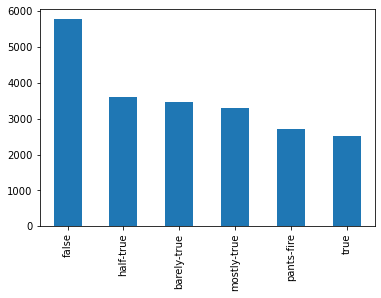

In [8]:
data['meter'].value_counts().plot(kind='bar')

<AxesSubplot:>

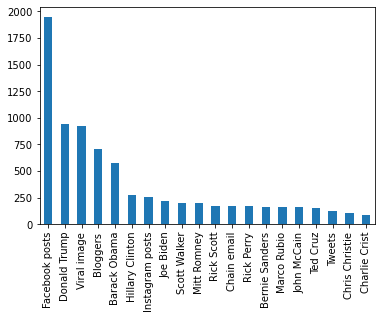

In [9]:
data['name_txt'].value_counts()[:20].plot(kind='bar')

In [10]:
data[data['name_txt'] == 'Facebook posts'].iloc[0]['quote_href']

'/factchecks/2022/mar/04/facebook-posts/ukrainian-president-not-frontline-military/'

<AxesSubplot:ylabel='Density'>

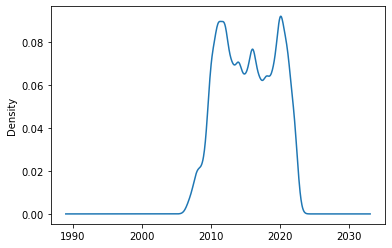

In [11]:
data['description_date'].dt.year.sort_values().plot.kde()

<AxesSubplot:>

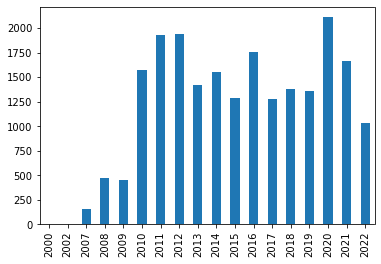

In [29]:
data['description_date'].dt.year.value_counts().sort_index().plot(kind='bar')